# Figure 3 - noise removal

The figure in this notebook illustrates: <br />
a) an example of a spectrogram from a section of an original recording <br />
b) Spectrogram of biophony after we applied the modified-ALE technique to the original spectrogram <br />
c) Spectrogram from a section of an original recording <br />
d) Spectrogram of biophony after we applied the modified-ALE technique to the original spectrogram <br />

#### import statements

In [1]:
from matplotlib import pyplot
%matplotlib inline
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import numpy
from scipy.io import wavfile

from os import path
from datetime import timedelta

from django.db import connection
from database.models import Sound
from database.models import Site

from nacoustik import Wave
from nacoustik.spectrum import psd
from nacoustik.noise import remove_background_noise, remove_anthrophony

from figutils import query, style

#### variable definitions

figure directory

In [2]:
figure_directory = ""

example recording 1

In [3]:
site1 = Site.objects.get(name='Höttinger Rain')
sound_db1 = Sound.objects.get(id=147)

example recording 2

In [4]:
site2 = Site.objects.get(name='Pfaffensteig')
sound_db2 = Sound.objects.get(id=158)

#### formating

In [5]:
style.set_font()

#### remove noise

remove noise from example recordings 1 and 2 using the adaptive level equalization algorithm

In [6]:
# example recording 1
wave1 = Wave(sound_db1.get_filepath())
wave1.read()
wave1.normalize()
samples1 = wave1.samples[(100 * wave1.rate):(160 * wave1.rate)]
duration = 60
f, t, a_pass = psd(samples1, rate=wave1.rate, window_length=512)
ale_pass = remove_background_noise(a_pass, N=0.18, iterations=3)
b_pass = remove_anthrophony(ale_pass, time_delta=t[1]-t[0], freq_delta=f[1]-f[0])
b_pass = numpy.ma.masked_equal(b_pass, value=0)

# example recording 2
wave2 = Wave(sound_db2.get_filepath())
wave2.read()
wave2.normalize()
samples2 = wave2.samples[(0 * wave2.rate):(60 * wave2.rate)]
duration = 60
f, t, a_fail = psd(samples2, rate=wave2.rate, window_length=512)
ale_fail = remove_background_noise(a_fail, N=0.18, iterations=3)
b_fail = remove_anthrophony(ale_fail, time_delta=t[1]-t[0], freq_delta=f[1]-f[0])
b_fail = numpy.ma.masked_equal(b_fail, value=0)

#### plot

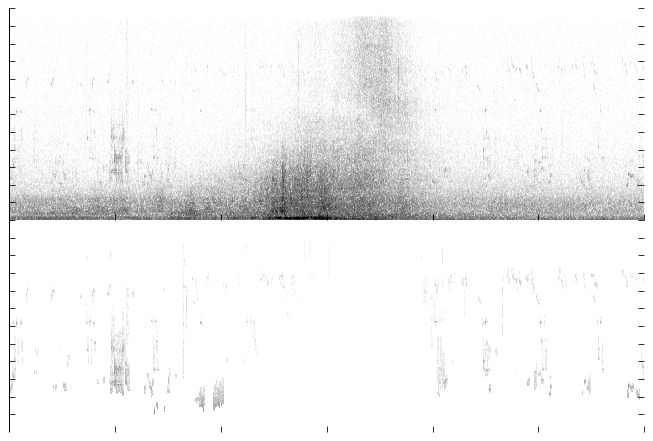

In [17]:
# create figure
figure3 = pyplot.figure()
#figure3.subplots_adjust(left=0.04, bottom=0.12, right=0.96, top=0.97, wspace=0, hspace=0)
figure3.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99, wspace=0, hspace=0)
figure3.set_figwidth(9)
figure3.set_figheight(6)

# specify frequency bins (width of 1 kiloherz)
bins = numpy.arange(0, (wave1.rate / 2), 1000)

# axes
ax_a = pyplot.subplot2grid((20, 1), (0, 0), rowspan=10, colspan=1)
ax_b = pyplot.subplot2grid((20, 1), (10, 0), rowspan=10, colspan=1, sharex=ax_a, sharey=ax_a)

# compute xlabels
start_time = sound_db1.get_datetime() + timedelta(seconds=100)
time_delta = 10
n = int((duration / time_delta) + 1)
xlabels_pass = [(start_time + timedelta(seconds=i*time_delta)).strftime("%H:%M:%S") for i in range(n)]
start_time = sound_db1.get_datetime()
xlabels_fail = [(start_time + timedelta(seconds=i*time_delta)).strftime("%H:%M:%S") for i in range(n)]
ylabels = ["", "2", "", "4", "", "6", "", "8", "", "10", "", ""]

# original - example 1
spec_1 = ax_a.pcolormesh(t, f, a_pass[0], cmap='Greys', vmin=-150, vmax=-80)
ax_a.set(ylim=([0, wave1.rate / 2]),
         yticks = bins.astype(numpy.int) + 1000)
ax_a.set_yticklabels(ylabels)
#ax_a.set_ylabel("frequency (kilohertz)")
ax_a.tick_params(length=6, color='black', direction='in',
                 bottom=True, labelbottom=False,
                 top=False, labeltop=False,
                 left=True, labelleft=False,
                 right=True, labelright=False)
ax_a.set_frame_on(False)

# after adaptive level equalization - example 1
spec_2 = ax_b.pcolormesh(t, f, b_pass[0], cmap='Greys', vmin=-150, vmax=-80)
ax_b.set(ylim=([0, wave1.rate / 2]),
              yticks = bins.astype(numpy.int) + 1000)
ax_b.set_xticklabels(xlabels_pass)
#ax_b.set_ylabel("frequency (kilohertz)")
ax_b.tick_params(length=6, color='black', direction='in',
                 bottom=True, labelbottom=False,
                 top=False, labeltop=False,
                 left=True, labelleft=False,
                 right=True, labelright=False)
ax_b.set_frame_on(False)
#ax_b.set_xlabel("time of day (hours:minutes:seconds)")

# axes borders
ax_a.add_line(Line2D([t[0], t[-1:]], [1, 1], color='black', linewidth=1))
ax_a.add_line(Line2D([t[0], t[0]], [0, 12000], color='black', linewidth=1))
ax_a.add_line(Line2D([t[-1:], t[-1:]], [0, 12000], color='black', linewidth=1))
ax_b.add_line(Line2D([t[0], t[-1:]], [1, 1], color='black', linewidth=1))
ax_b.add_line(Line2D([t[0], t[0]], [0, 12000], color='black', linewidth=1))
ax_b.add_line(Line2D([t[-1:], t[-1:]], [0, 12000], color='black', linewidth=1))

#### save figure

In [18]:
#figure3.savefig(path.join(figure_directory, "figure3.png"), dpi=300)
figure3.savefig('/Users/jake/Desktop/figure.png', dpi=600)